In [35]:
import Utilities.prelude
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import k3match
from tqdm import tqdm
import pickle 
import math 
import matplotlib
import numba
from numba_kdtree import KDTree

from src.shock_zone import find_prepost#,shock_direction
from Utilities.operators import make_tree#, calc_grad

matplotlib.rcParams['figure.dpi'] = 100
# %matplotlib widget # (to go back normal %matplotlib inline)
# mpl.rcParams['figure.dpi'] = 100

In [2]:
z_chosen = 0
mach_min = 1.3
gamma = 5/3
save = False
folder = 'TDE'
snap = '196'
m = 5
path = f'{folder}/{snap}'

if folder == 'TDE':
    is_tde = True
    cross_section = False
    x_chosen = 10
    y_chosen = -5
    xepsilon = 0.5
    yepsilon = 0.5
    epsilon = 0.02
elif folder == 'sedov':
    is_tde = False
    epsilon = 0.02
    cross_section = False

In [3]:
def find_Tmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    a = 2*gamma*(gamma-1)
    minusb = gamma*2 - 6*gamma + ratio*(gamma+1)**2 + 1
    msquared = (minusb + np.sqrt(minusb**2 + 8*a*(gamma-1))) / (2*a)
    return np.sqrt(msquared)

def find_Pmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    msquared = (ratio * (gamma+1) + gamma - 1) / (2*gamma)
    return np.sqrt(msquared)

def find_Denmach(ratio, gamma):
    """ Find mach nuber from the temperature jump (ratio)."""
    denom = gamma + 1 - ratio * (gamma-1)
    msquared = 2 * ratio / denom
    return np.sqrt(msquared)

@numba.njit
def searching_tree(tree, point):
    _, idx, _ = tree.query(point)
    idx = idx[0]
    return idx[0]

def find_prepost(sim_tree, X, Y, Z, point, check_point, ds, delta, direction):
    """ Find the previous/next point along the shock direction.
    Parameters
    -----------
    point: array.
        Starting point.
    ds: array (1x3)
        Shock direction.
    delta: float.
        Step to do to search.
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns
    -----------
    idx: int.
        Tree index of the previous/next point along the shock direction.
    """
    if direction == 'post':
        delta = - delta
        
    k = 1
    # check that you are not taking the same point as the one given
    distance = 0
    while distance == 0:
        new_point = point + k * delta * ds 
        idx  = searching_tree(sim_tree, new_point) # sim_tree.query(new_point)
        new_point = np.array([X[idx], Y[idx], Z[idx]])
        distance = math.dist(check_point, new_point)
        k += 0.1

    k -=0.1 #becuase you have added it in the end
    final_step = k*np.abs(delta)
    return idx, final_step


In [4]:
def ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, all_idx, idx, div, dir, direction):
    """ Start from one cell and walk along the shock direction till you go out the shock zone accoridng to Schaal14 (par 2.3.3).
    Parameters
    -----------
    sim_tree: tree.
        Simualation points. 
    X, Y, Z: arrays.
        Points coordinates.
    are_u_shock: bool array.
        Says if a simulation cell is in the shock zone.
    x_zone, y_zone, z_zone: arrays.
        Shock zone points coordinates.
    all_idx: array.
        Tree indeces identifying the cells in the shock zone.
    idx: int.
        Index of the chosen point between the one in the shock zone.
    div: array.
        Velocity divergence of the shock zone points.
    dir: 3D-array.
        Shock direction of the shock zone points.
    delta: float.
        Step you do from your chosen point. It has to be positive!
    direction: str.
        Choose if you want to move towards the 'pre' or 'post' shock region.
    Returns:
    -----------
    final_tree_index: int.
        Tree index of the pre/post shock cell corresponding to the starting one.
    """
    # Take the necessary info of your starting point 
    x_point = x_zone[idx]
    y_point = y_zone[idx]
    z_point = z_zone[idx]   

    point = np.array([x_point, y_point, z_point])
    r_point = np.linalg.norm(point)
    div_v = div[idx]
    dir_sh = np.array(dir[idx])
    
    _, _, dist = k3match.cartesian(X,Y,Z, x_point, y_point, z_point, 2*r_point)
    dist = np.delete(dist, np.argmin(dist))
    delta = np.min(dist)
    
    # Walk till you go out the shock zone
    check_zone = True 
    check_point = point
    while check_zone == True:
        # Find the next point
        i_tree, final_step = find_prepost(sim_tree, X, Y, Z, point, check_point, dir_sh, delta, direction)
        # check if it's in the shock zone
        check_zone = are_u_shock[i_tree]

        if check_zone == True:
            # there will be a index in all_idx equal to i_tree. Find it. 
            idx_zone = np.argmin(np.abs(i_tree-all_idx))  
            # Take the div and dir of that (shock zone) point.
            div_next = div[idx_zone]
            dir_next = dir[idx_zone]

            # if lower div v, you discard the ray.
            if div_next < div_v:
                return False # and then you don't take this cell

            # if opposite direction in shocks, you turn/stop.
            if np.dot(dir_sh, dir_next) < 0:
                check_zone = False # so you exit from the while
        
        check_point = np.array([X[i_tree], Y[i_tree], Z[i_tree]])
        delta = final_step
 
    final_tree_index = i_tree
    
    return final_tree_index

def shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, x_zone, y_zone, z_zone, all_idx, div, dir):
    """ 
    Find among the cells in the shock zone the one in the shock surface 
    (output: indeces referring to the shockzonefile) 
    and its pre/post shock cells (output: tree indeces).
    """
    surface_Tmach = []
    surface_Pmach = []
    surface_Denmach = []

    #indeces referring to the shockzone file: you use them on xyz_zone and dir
    indeces = [] 
    # indeces referring to the list of ALL simulation cells: you use them on XYZ
    indeces_pre = []
    indeces_post = []

    # loop over all the cells in the shock zone
    for idx in range(len(x_zone)):
        x_point = x_zone[idx]
        y_point = y_zone[idx]
        z_point = z_zone[idx]

        if x_point < 3 or x_point > 30 or y_point < -18 or y_point > 23 or np.abs(z_point)<0.125: 
            continue
       
        print(idx)

        post_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                     all_idx, idx, div, dir, direction = 'post')
        if post_tree_index == False:
            continue
        else:
            Tpost = Temp[post_tree_index]
            pre_tree_index = ray_tracer(sim_tree, X, Y, Z, are_u_shock, x_zone, y_zone, z_zone, 
                                        all_idx, idx, div, dir, direction = 'pre')
            if pre_tree_index == False:
                continue
            else:
                Tpre = Temp[pre_tree_index]

                Tbump = Tpost/Tpre
                # check if the Tbump is in the same direction of ds 
                if Tbump < 1:
                    continue 

                # We should also avoid the cells with Tbump< than the one (1.2921782544378697) inferred from M=M_min... So condition 2 doesn't work in shock zone?
                # This already happen using Elad's gradient, not with my approximation
                # if Tbump < 1.292:
                #     continue 

                indeces.append(idx)
                indeces_pre.append(pre_tree_index)
                indeces_post.append(post_tree_index)
                
                Ppre = Press[pre_tree_index]
                Ppost = Press[post_tree_index]
                Pbump = Ppost/Ppre
                Denpre = Den[pre_tree_index]
                Denpost = Den[post_tree_index]
                Denbump = Denpost/Denpre
                
                Tmach = find_Tmach(Tbump, gamma)
                Pmach = find_Pmach(Pbump, gamma)
                Denmach = find_Denmach(Denbump, gamma)

                surface_Tmach.append(Tmach)
                surface_Pmach.append(Pmach)
                surface_Denmach.append(Denmach)
            
    surface_Tmach = np.array(surface_Tmach)
    surface_Pmach = np.array(surface_Pmach)
    surface_Denmach = np.array(surface_Denmach)
    indeces = np.array(indeces)
    indeces_pre = np.array(indeces_pre)
    indeces_post = np.array(indeces_post)

    return surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post


In [38]:
sim_tree, X, Y, Z, Vol, VX, VY, VZ, Den, Press, Temp = make_tree(path, snap, is_tde)
dim_cell = (3*Vol/(4*np.pi))**(1/3)

In [39]:
print(len(X))

17539687


In [44]:
# Import data
with open(f'data/{snap}/areushock_{snap}.pkl', 'rb') as filebool:
    are_u_shock = pickle.load(filebool)
    
shockzone = np.loadtxt(f'data/{snap}/shockzone_{snap}.txt')

idx_tree = shockzone[0]
div = shockzone[1]
x_dir = shockzone[2]
y_dir = shockzone[3]
z_dir = shockzone[4]

idx_tree = np.array([int(i) for i in idx_tree])
x_zone = X[idx_tree]
y_zone = Y[idx_tree]
z_zone = Z[idx_tree]
Tzone = Temp[idx_tree]
dim_cell_zone = dim_cell[idx_tree]

dir = []
for i in range(len(x_dir)):
    dir.append([x_dir[i], y_dir[i], z_dir[i]])

In [7]:
if cross_section:
    conditions_Eladx = np.logical_and(x_zone>3, x_zone<30)
    conditions_Elady = np.logical_and(y_zone>-18, y_zone<23)
    conditions = np.logical_and(np.abs(z_zone) < dim_cell_zone, np.logical_and(conditions_Eladx, conditions_Elady))
    x_cross_zone = x_zone[conditions]
    y_cross_zone = y_zone[conditions]
    z_cross_zone = z_zone[conditions]
    idx_cross_tree = idx_tree[conditions]
    x_cross_dir = x_dir[conditions]
    y_cross_dir = y_dir[conditions]
    z_cross_dir = z_dir[conditions]
    div_cross = div[conditions]

    dir_cross = []
    for i in range(len(x_cross_zone)):
        dir_cross.append([x_cross_dir[i], y_cross_dir[i], z_cross_dir[i]])
        
    print(len(x_cross_zone))
    surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, 
                                                                                                      x_cross_zone, y_cross_zone, z_cross_zone, 
                                                                                                      idx_cross_tree, div_cross, dir_cross)
else:
    print('no cross section', len(x_zone))
    surface_Tmach, surface_Pmach, surface_Denmach, indeces, indeces_pre, indeces_post = shock_surface(sim_tree, X, Y, Z, Temp, Press, Den, are_u_shock, 
                                                                                                      x_zone, y_zone, z_zone, idx_tree, div, dir)

no cross section 12363
195
197


/var/folders/s6/3n46ppqn3jx7765w8c686c740000gn/T/ipykernel_8982/2377259705.py:17: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(msquared)


199
200
201
202
203
204
205
206
207
208
209
210
215
216
218
219
220
221
222
223
224
225
226
227
228
229
230
232
233
234
235
237
239
240
241
242
243
244
245
247
248
251
283
286
287
288
289
291
292
293
294
295
296
297
298
299
302
305
306
307
308
332
334
335
336
337
338
339
340
384
385
386
387
388
389
390
398
411
413
414
416
417
418
420
421
422
424
434
437
438
440
441
442
444
577
578
579
580
581
582
583
585
587
589
591
592
593
594
595
596
597
599
601
608
612
613
615
632
633
635
658
659
660
661
677
678
679
680
681
682
683
684
685
686
687
689
690
691
711
712
716
718
722
725
730
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
750
751
752
753
754
755
756
757
759
761
762
763
764
765
766
767
768
769
770
771
773
774
775
778
781
783
786
789
791
793
794
796
798
803
804
805
806
807
808
809
810
812
813
814
816
825
827
828
829
830
833
834
836
837
838
839
840
841
842
843
845
846
849
850
852
854
858
859
860
862
863
865
867
868
871
872
873
874
880
881
884
885
887
889
893
895
896
897


In [25]:
save = True

In [26]:
if save == True:
    with open(f'data/{snap}/shocksurface_{snap}.txt', 'w') as file:
        file.write(f'# Indeces of the shock zone points that are in the shock surface (I.E. they refer to the shockzone file) \n') 
        file.write(' '.join(map(str, indeces)) + '\n')
        file.write('# mach number according to T jump\n') 
        file.write(' '.join(map(str, surface_Tmach)) + '\n')
        file.write('# mach number according to P jump\n') 
        file.write(' '.join(map(str, surface_Pmach)) + '\n')
        file.write('# mach number according to Den jump\n') 
        file.write(' '.join(map(str, surface_Denmach)) + '\n')
        file.write(f'# Tree indeces of the pre shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_pre)) + '\n')
        file.write(f'# Tree indeces of the post shock zone points corresponding to the shock surface points \n') 
        file.write(' '.join(map(str, indeces_post)) + '\n')
        file.close()
    

In [27]:
#if folder == 'sedov':    
surface_x = x_zone[indeces]
surface_y = y_zone[indeces]
surface_z = z_zone[indeces]
surface_dirx = x_dir[indeces]
surface_diry = y_dir[indeces]
epsilon_surf = dim_cell_zone[indeces]
    
# else:
#     surface_x = x_cross_zone[indeces]
#     surface_y = y_cross_zone[indeces]
#     surface_z = z_cross_zone[indeces]
#     surface_dirx = x_cross_dir[indeces]
#     surface_diry = y_cross_dir[indeces]

    # with open(f'data/{snap}/shocksurface_{snap}.txt', 'a') as file:
    #     file.write(f'# x surface \n') 
    #     file.write(' '.join(map(str, surface_x)) + '\n')
    #     file.write('# y surface \n') 
    #     file.write(' '.join(map(str, surface_y)) + '\n')
    #     file.write('#z surface\n') 
    #     file.write(' '.join(map(str, surface_z)) + '\n')

post_x = X[indeces_post]
post_y = Y[indeces_post]
post_z = Z[indeces_post]
pre_x = X[indeces_pre]
pre_y = Y[indeces_pre]
pre_z = Z[indeces_post]

epsilon_post = dim_cell[indeces_post]
epsilon_pre = dim_cell[indeces_pre]
    


In [28]:
# Cross section
if folder == 'sedov':
    zone_cross_x = x_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]
    zone_cross_y = y_zone[np.abs(z_zone-z_chosen)< dim_cell_zone]

    surface_cross_x = surface_x[np.abs(surface_z-z_chosen)< epsilon_surf]
    surface_cross_y = surface_y[np.abs(surface_z-z_chosen)< epsilon_surf]

    cross_shockdirx = surface_dirx[np.abs(surface_z-z_chosen)< epsilon_surf]
    cross_shockdiry = surface_diry[np.abs(surface_z-z_chosen)< epsilon_surf]

    zone_post_x = post_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(post_z-z_chosen)<epsilon_post)] # post_x[np.abs(surface_z-z_chosen)<epsilon_surf] 
    zone_post_y = post_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(post_z-z_chosen)<epsilon_post)] # post_y[np.abs(surface_z-z_chosen)<epsilon_surf]

    zone_pre_x = pre_x[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(pre_z-z_chosen)<epsilon_pre)] # pre_x[np.abs(surface_z-z_chosen)<epsilon_surf]
    zone_pre_y = pre_y[np.logical_and(np.abs(surface_z-z_chosen)<epsilon_surf, np.abs(pre_z-z_chosen)<epsilon_pre)] # pre_y[np.abs(surface_z-z_chosen)<epsilon_surf]


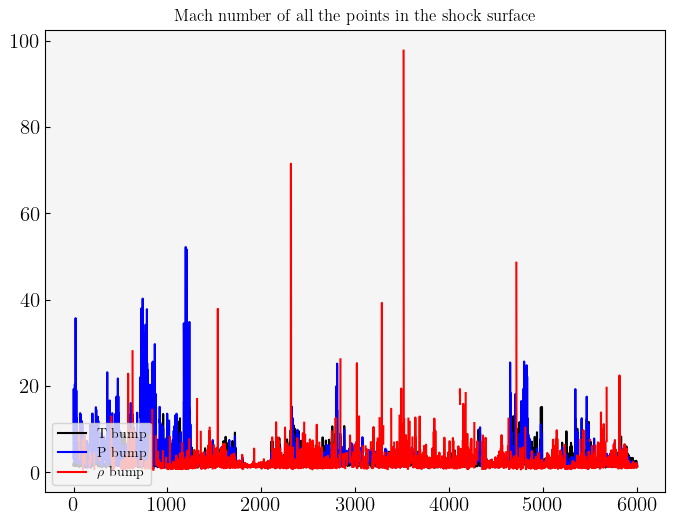

In [29]:
plt.plot(surface_Tmach, c = 'k', label = 'T bump')
plt.plot(surface_Pmach, c = 'b', label = 'P bump')
plt.plot(surface_Denmach, c = 'r',  label = r'$\rho$ bump')
plt.title(f'Mach number of all the points in the shock surface')
plt.legend(loc = 'lower left')
if save:
    plt.savefig(f'Figs/{snap}/mach{snap}.png')

Compare with old data

In [30]:
if snap == '100':
    oldadata = np.loadtxt(f'data/100/mygrad/shocksurface_100.txt')
    machTold = oldadata[1]
    machPold = oldadata[2]
    machDenold = oldadata[3]
    newadata = np.loadtxt(f'data/100/shocksurface_100.txt')
    machTnew = newadata[1]
    machPnew = newadata[2]
    machDennew = newadata[3]

    plt.plot(machTnew, c = 'k', label = 'T bump now')
    plt.plot(machPnew, c = 'b', label = 'P bump now')
    plt.plot(machDennew, c = 'r',  label = r'$\rho$ bump now')
    plt.plot(machTold, c = 'silver', linestyle = '--', label = 'T bump old')
    plt.plot(machPold, c = 'skyblue',  linestyle = '--', label = 'P bump old')
    plt.plot(machDenold, c = 'orange', linestyle = '--', label = 'Den bump old')
    plt.title(f'Mach number in snap 100: new (gradients by Elad) and old (my approximation) values')
    plt.legend(loc = 'lower left')
    if save:
        plt.savefig(f'Figs/100/compareMYGRAD_mach{snap}.png')

In [31]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (9,9))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 5, markeredgecolor='coral', label = 'Shock zone')
    ax.plot(surface_cross_x, surface_cross_y, 'ks', markerfacecolor='maroon', ms = 4, markeredgecolor='none',  alpha = 0.8, label = 'Shock surface')

    ax.plot(zone_post_x, zone_post_y, 'ks', markerfacecolor='sandybrown', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Post shock')
    ax.plot(zone_pre_x, zone_pre_y, 'ks', markerfacecolor='lightskyblue', ms = 5, markeredgecolor='none', alpha = 0.8,  label = 'Pre shock')
    ax.quiver(surface_cross_x, surface_cross_y, cross_shockdirx, cross_shockdiry, color = 'k', angles='xy', scale_units='xy', width = 3e-3)#, scale = 20)

    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.legend()
    ax.set_title(r'z = V$^{1/3}$', fontsize = 16)
    plt.grid()
    if save == True:
        plt.savefig(f'Figs/{snap}/5shocksurface_thirdV_{snap}.png')


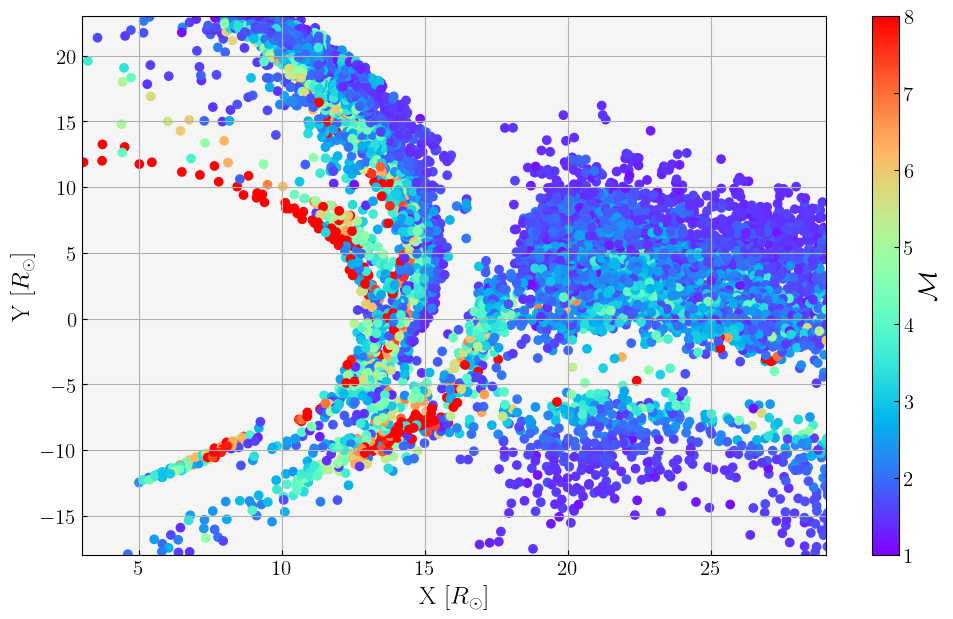

In [32]:
# Maybe for every cell of the shock surface you don't see pre/post because they are not on the same layers
fig, ax = plt.subplots(1,1, figsize = (12,7))
if folder == 'sedov':
    fig, ax = plt.subplots(1,1, figsize = (10,8))
    ax.plot(zone_cross_x, zone_cross_y, 'ks', markerfacecolor='none', ms = 6, markeredgecolor='k', alpha = 0.2, label = 'Shock zone')
    img = ax.scatter(surface_cross_x, surface_cross_y, c = surface_Tmach[np.abs(surface_z-z_chosen)<epsilon_surf], s=10,  cmap = 'rainbow', label = 'Shock surface')#, vmin = 110, vmax = 160)
    ax.set_xlim(-1.1,1.1)
    ax.set_ylim(-1.1,1.1)
    ax.set_xlabel('X', fontsize = 18)
    ax.set_ylabel('Y', fontsize = 18)
    ax.legend()
else: 
    on_apocenter = False
    Mbh = 10**m 
    Rt =  Mbh**(1/3) # Msol = 1, Rsol = 1
    if on_apocenter:
        apocenter = 2 * Rt * Mbh**(1/3)
    else:
        apocenter = 1
    img = ax.scatter(surface_x/apocenter, surface_y/apocenter, c = surface_Tmach, label = 'Shock surface', cmap = 'rainbow', vmin=1, vmax = 8)
    if on_apocenter:
        plt.ylim(-0.3, 0.2)
        plt.xlim(-1,0.05)
        plt.xlabel(r'X [$x/R_a$]', fontsize = 18)
        plt.ylabel(r'Y [$y/R_a$]', fontsize = 18)
    else:
        ax.set_xlim(3,29)
        ax.set_ylim(-18,23)
        plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
        plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
        
cbar = plt.colorbar(img)
cbar.set_label(r'$\mathcal{M}$', fontsize = 19)
plt.grid()
if save == True:
    if folder == 'sedov':
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_thirdV_{snap}.png')
    else:
        plt.savefig(f'Figs/{snap}/5shocksurfaceMach_{snap}.png')
plt.show()

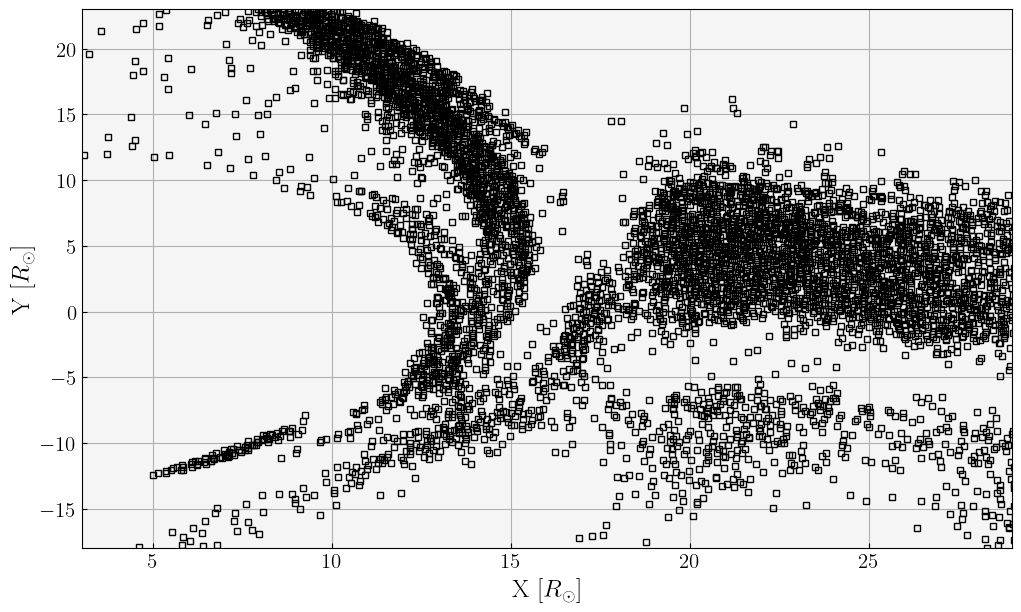

In [33]:
fig, ax = plt.subplots(1,1, figsize = (12,7))
ax.plot(surface_x, surface_y, 'ks', markerfacecolor='none', ms = 4, markeredgecolor='k',label = 'Shock surface')
ax.set_xlim(3,29)
ax.set_ylim(-18,23)
plt.xlabel(r'X [$R_\odot$]', fontsize = 18)
plt.ylabel(r'Y [$R_\odot$]', fontsize = 18)
plt.grid()